## CS4305TU Applied Machine Learning. Week 8 Assignment (Recurrent Neural Networks)

### Identification of water end-uses using Deep Learning Neural Networks


Welcome to the assignment for Week 8 of your Applied Machine Learning course. In this assigment, you will be tasked with _classifying water end-uses from smart water meter data_ using Deep Learning techniques. 

<u> Background </u>

With the progressive digitalization of the water sector, many residential buildings around the world have now smart water meters installed to measure water consumption. While this information is mainly used for billing purposes, water utilities are figuring out ways to employ this data for implementing sustainable water management strategies. After addressing relevant privacy and ethical issues, analysts can use high-resolution smart meter recordings to identify consumer behaviours and detect leaks occurring within the building. This in turn can lead to substantial water savings.

While installing a smart water meter in a household is rather easy, accurate mapping of consumer behaviour entails breaking down the total household water consumption (measured by the smart meter) into **water end-uses**, such as water used for faucets, toilets, showers, washing machines, lawn irrigation, etc. Understanding these end-uses will enable water utilities and household owners to determine where water is wasted, how much and how often, and plan strategies to optimize consumption or identify leaks. 

To perform this _disaggregation_, analyst usually resort to surveys and checklists, where they ask volunteer households to keep track of their individual consumptions for days as their total consumption is recorded. An alternative approach would be to monitor at the same time total consumption with a smart water meter along with (all) individual end-uses with less intrusive flow meters, as illustrated in Figure 1. This setting enables gathering high-resolution and more accurate data. 

<center><figure>
  <img src="https://drive.google.com/uc?id=18PhgHUTbkxIIpi7Q7zY6q_u3_jjUlWSX" width=600/>
<figcaption>Figure 1. Household with collective smart water meter and water end-uses flow meters. 

<sub><sup>Image credits to https://droughtresources.unl.edu/household-water-use, lcongeek26 and Good Ware from www.flaticon.com. </sup></sub></figcaption>
</figure></center>

<u> Problem defintion </u>

A water utility has carried out an extensive water monitoring campaign involving several households. Following the scheme of Figure 1, smart water meters (totalizers) and individual flow meters have been installed for six common end-uses/appliances:
- Toilet;
- Shower;
- Faucets (taps of different kinds);
- Clotheswasher;
- Dishwasher;
- Bathub.

As an analyst of the water utility, your task is to develop an AI-based tool that can perform the multi-class classification shown in Figure 2. Your system will process sequences of readings from the smart water meter, recognize the _signature_ of the particular end-use, and assign it to one of the possible classes. You will develop this tool in a _supervised learning_ manner by employing the labeled datasets made available during the monitoring campaign. If your system generalizes well to unseen data, the water utility will include it in an app for its customers, to allow them to monitor their own consumptions and identify leaks via automatic processing of their smart water meter readings.


<center><figure>
  <img src="https://drive.google.com/uc?id=1gDQeE38Q5AZBBIlmCgSdIOxmgV0XyaAX" width=800/>
<figcaption>Figure 2. Multi-class classification of end-use signature.</figcaption>
</figure></center>

<u> Dataset details </u>

The dataset you will use is created using STREaM, a realistic generator of residential water end-uses (https://github.com/acominola/STREaM). For simplicity, the data does not include water leakages in the pipes or simultaneous occurrance of multiple end-uses. Time series are recorded with a sampling rate of 10 seconds. In the next section, the original dataset is partially illustrated, before the actual *training*, *validation* and *test* dataset are created. The inputs will be made of 10 minutes long **sequences** of smart water meter recordings, that is 60 datapoints spaced at 10 seconds (lenght of sequence _L=60_). The outputs will be **one-hot encoded arrays**, that is vectors with all zeros apart from a single end-use. 

---
---


#### Link to Google Drive and Load python modules

In [ ]:
# link to Google Drive to access files
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

!ls gdrive 

Mounted at /content/gdrive/
'My Drive'


In [ ]:
# generic modules
import datetime, os
import itertools
import time

# append working folder
import sys
working_folder = './gdrive/My Drive/CS4305TU_RNN/'
sys.path.append(working_folder)


# basic data science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import tensorflow_addons as tfa
import tensorflow as tf

# sklearn helper functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import time 

# import additional helper scripts 
# [NOTE: USE THESE FUNCTIONS, IF YOU WANT, TO COMPUTE THE NUMBER OF WEIGHTS OF ANNs AND PLOT THE CONFUSION MATRIX]
# from assignment_utils import *

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K


def get_trainable_params(model):
    # this function returns the number of trainable parameters in a Keras model
    return np.sum([K.count_params(w) for w in model.trainable_weights]).astype(int)
  
  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,figsize=(5,5)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
    else:
      print('Confusion matrix, without normalization')
    
    print(cm)
    
    f, ax = plt.subplots(1,figsize=figsize)
    ax.imshow(cm, interpolation='nearest', cmap=cmap,)
    ax.set_title(title)
    # ax.setcolorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      ax.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
    
    f.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

#### Load original and visualize dataset

In [ ]:
# load data
filename = 'household_water_consumption_identification.csv'
df = pd.read_csv(working_folder+filename)

In [ ]:
df.head()

,h,m,s,toilet,shower,faucet,clotheswasher,dishwasher,bathtub,household,episode
0,2,20,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2,20,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2,20,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2,20,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2,20,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


The original dataset is in tabular form. The columns contain information on:
- the timestamp of each recording (no date, only time in hour, minutes, seconds);
- the volume of water at each timestamp for each water end-use;
- the overal volume of water consumed by the _household_ in that timestamp;
- the _episode_ (10 minutes long sequence) to which the recording belongs.

In [ ]:
# water end-uses/appliances
end_uses = ['toilet','shower','faucet','clotheswasher','dishwasher','bathtub']

Let us quickly visualize typical singatures for each end use. 

<u>Run the cell below multiple times with a differen random seed to see different events for each water end-use</u>.

<sub>_Note:_ Is not important if you do not understand everything the code below; focus on the visualized results.</sub>

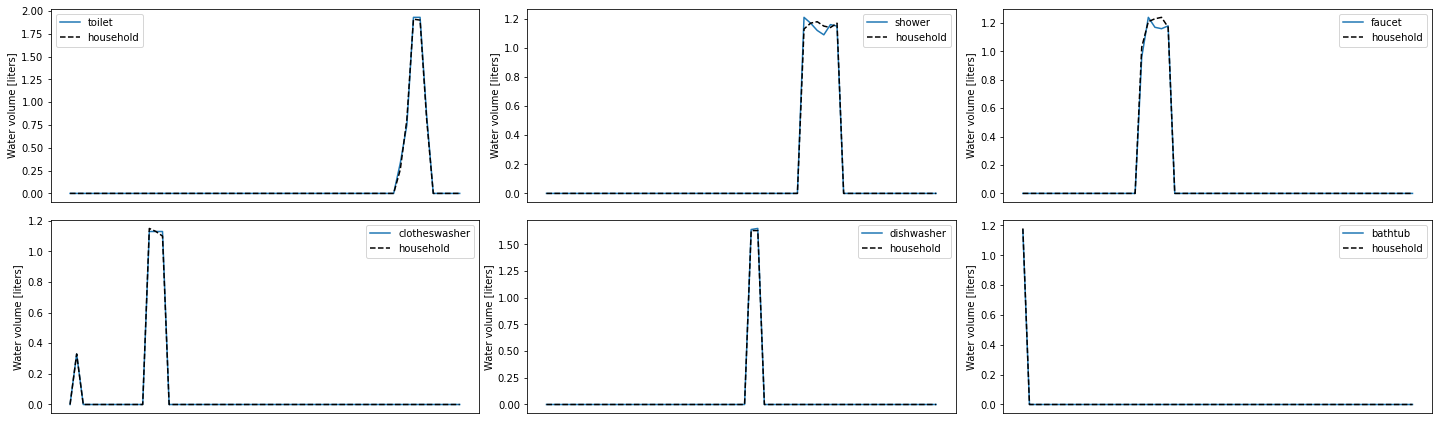

In [ ]:
# choose random seed
np.random.seed(666)

# initialize figure with subplots
f, axes = plt.subplots(2,3, figsize=(20,6))

# grouped dataset 
temp = df.groupby('episode').sum()[end_uses]

for ax, end_use in zip(axes.reshape(-1),end_uses):
  # select one episode at random for each end_use
  episodes_with_end_use = temp[temp[end_use]>0].index.tolist()
  episode = np.random.choice(episodes_with_end_use)
  df.groupby('episode').get_group(episode)[end_use].plot(label=end_use, ax=ax);
  df.groupby('episode').get_group(episode)['household'].plot(ls='--', c='k', label='household', ax=ax);
  ax.set_xticks([])  
  ax.set_ylabel('Water volume [liters]')
  ax.legend()
f.tight_layout()

You can see that measurments taken locally for each end-use differ slightly from the recordings at household level. This is because the flow sensors and smart water meter are different instruments, with different accuracies and subject to different noise.

Let's now check if there is only 1 water end-use for each episode and let's check how many epsisodes are related to each type of end-use. This can be perfomed, for instance, after creating an auxiliary dataframe by grouping the original dataset by each episode and summing and individual water consumptions together within each episode. 


<sub>_Note:_ Is not important if you do not understand everything the code below; focus on the visualizeed results.</sub>

In [ ]:
temp = df.groupby('episode')[end_uses].sum()
temp.head()

,toilet,shower,faucet,clotheswasher,dishwasher,bathtub
episode,,,,,,
1,6.95,0.0,0.00,0.00,0.0,0.00
6,0.00,0.0,0.00,2.63,0.0,0.00
21,0.00,0.0,0.00,3.09,0.0,0.00
37,0.00,0.0,0.00,0.00,0.0,7.13
141,0.00,0.0,9.12,0.00,0.0,0.00


Now we check whether each cell is greater than zero and by summing instances row-wise and column-wise we can answer the two questions. You can do this by specifying the correct axis.

toilet           14205
shower           12577
faucet           19687
clotheswasher    12147
dishwasher       11573
bathtub           6849
dtype: int64


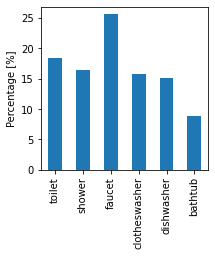

In [ ]:
# check if we only have one end use for each episode
(temp>0).sum(axis=1).unique()

# check water end use distribution 
print((temp>0).sum(axis=0))
n_episodes = len(temp)
(((temp>0).sum(axis=0)/n_episodes)*100).plot(kind='bar', figsize=(3,3))
plt.gca().set_ylabel('Percentage [%]');

We now know that we have exactly a single end use for each recorded episode, and that we have a slightly unbalanced datasets: *faucets* are more represented than the remaining items. *Bathub* events are less common than the others.

#### Creation of training, validation and test datasets.

We now create the final datasets that you will be using for this assignment. You are tasked with identifying end-uses by their signature as recorded by the smart water meter during each episode. As such, each input entry of your dataset will be a **sequence** of lenght $L = 60$, while outputs are **one-hot encoded vectors** with all zeros apart from the appliance/end-use

<sub>_Note:_ Is not important if you do not understand everything the code below. Just make use correctly of the datasets for the remainder of your assignment.</sub>

In [ ]:
def create_dataset(df):
  # group each episode (they will be sorted automatically based on current order)
  df_grouped = df.groupby('episode')
  X,Y = [],[]
  for group_name, df_group in df_grouped:
    x = df_group.household.values
    X.append(x)
    y = df_group[end_uses].values
    Y.append(y.sum(axis=0)>0)
  X = np.array(X)
  Y = np.array(Y)
  return X,Y

# tra = training, val = validation (early stopping), tst = testing (unseen)
L = 60 # 10 minutes episode length, sampled every 10 seconds
X,Y = create_dataset(df)
Xtra,Xval,Ytra,Yval = train_test_split(X,Y,test_size=0.25,shuffle=False)
Xval,Xtst,Yval,Ytst = train_test_split(Xval,Yval,test_size=0.5,shuffle=False)

print(f"X.shape: {Xtra.shape}, Y.shape: {Ytra.shape}")
print(f"X.shape: {Xval.shape}, Y.shape: {Yval.shape}")
print(f"X.shape: {Xtst.shape}, Y.shape: {Ytst.shape}")

X.shape: (57778, 60), Y.shape: (57778, 6)
X.shape: (9630, 60), Y.shape: (9630, 6)
X.shape: (9630, 60), Y.shape: (9630, 6)


In [ ]:
# rescale input dataset (no need for outputs as they are are one-hot-encoded classes)
Sx=MinMaxScaler([0,1])
Xtra = Sx.fit_transform(Xtra)
Xval = Sx.transform(Xval)
Xtst = Sx.transform(Xtst) 

### Beginning of assignment!

#### Part 1. <u> Train a Feed-forward Neural Network that will be used as benchmark</u>.

You are asked to train several FNNs architectures (between 5 and 10) in order to identify a good benchmark for the *water end-use multiclass classification problem*. The benchmark model will be refined later in the assignment. 

_Instructions_
- Try single layer as well as double layer FNNs;
- Limit the total number of neurons in each layer to 100;
- Use dropout and early stopping (callback) to reduce overfitting;
- Limit training epochs to 200 and use time stopping (callback) to reduce computational time to a max of 5 minutes for each model;
- Use the Adam optimizer, and set learning rate to 0.010;
- Use a batch size of 256.

_Questions_
- For each trained architecture, store the *best value for the validation loss*, *number of trainable parameters*, and *training time*;
- Select the benchmark architecture and motivate why. This FNN will be refined later along with the most promising RNN architecture.
- Plot the training/validation history of the selected FNN architecture

In [ ]:
# practice test_model

# code adapted from provided 'UrbanFloodingForecasting.ipynb' and 'Different_RNNs_and_trainable_parameters.ipynb'

# Function for model creation
def FNNmodel(n_hidden_neurons=10, dropout_rate=0.1, FNN_layer=  1):

  if FNN_layer == 1:
    i = Input(shape=(L,))      
    x = Dense(10, activation='sigmoid', name='Hidden_layer_1')(i)
    x = Dropout(dropout_rate)(x)
    x = Dense(6, activation='sigmoid', name='Output')(x)  
    model = Model(i,x)

  elif FNN_layer == 2:
    i = Input(shape=(L,))      
    x = Dense(10, activation='sigmoid', name='Hidden_layer_1')(i)
    x = Dense(10, activation='sigmoid', name='Hidden_layer_2')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(6, activation='sigmoid', name='Output')(x)  
    model = Model(i,x)

  return model

In [ ]:
# practice test_model

# code adapted from provided 'UrbanFloodingForecasting.ipynb'

model_test = FNNmodel(n_hidden_neurons = 100, dropout_rate = 0.01, FNN_layer=  2)

In [ ]:
# practice test_model
model_test.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 10)                610       
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 10)                110       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
Output (Dense)               (None, 6)                 66        
Total params: 786
Trainable params: 786
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# practice test_model

# code adapted from provided 'UrbanFloodingForecasting.ipynb'

model_test.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01), metrics=['accuracy'])
r = model_test.fit(Xtra, Ytra,epochs=30,validation_data = (Xval, Yval), verbose=0, batch_size=256)

In [ ]:
# practice test_model
r.history

{'accuracy': [0.2539721131324768,
  0.3790023922920227,
  0.3861331343650818,
  0.38445428013801575,
  0.3846619725227356,
  0.3895254135131836,
  0.4010522961616516,
  0.40717920660972595,
  0.41098687052726746,
  0.4134964942932129,
  0.4157464802265167,
  0.4191041588783264,
  0.41818684339523315,
  0.4221675992012024,
  0.42330992221832275,
  0.4248676002025604,
  0.4290906488895416,
  0.4321887195110321,
  0.431963711977005,
  0.43462908267974854,
  0.4376233220100403,
  0.43899062275886536,
  0.4374329447746277,
  0.439959853887558,
  0.4431617558002472,
  0.4440271258354187,
  0.44638097286224365,
  0.44958287477493286,
  0.4491155743598938,
  0.4523521065711975],
 'loss': [0.4539576470851898,
  0.3751969039440155,
  0.35958150029182434,
  0.35233378410339355,
  0.34551095962524414,
  0.34076300263404846,
  0.33657822012901306,
  0.333344429731369,
  0.3307638168334961,
  0.3290884494781494,
  0.327791690826416,
  0.3266727030277252,
  0.3258238732814789,
  0.325186550617218,
  

In [ ]:
# code adapted from provided 'UrbanFloodingForecasting.ipynb' and 'Different_RNNs_and_trainable_parameters.ipynb'

# function for model creation
def FNNmodel(n_hidden_neurons=10, dropout_rate=0.1, FNN_layer=  1):

  if FNN_layer == 1:
    i = Input(shape=(L,))      
    x = Dense(neurons, activation='sigmoid', name='Hidden_layer_1')(i)
    x = Dropout(dropout_rate)(x)
    x = Dense(6, activation='sigmoid', name='Output')(x)  
    model = Model(i,x)

  elif FNN_layer == 2:
    i = Input(shape=(L,))      
    x = Dense(neurons, activation='sigmoid', name='Hidden_layer_1')(i)
    x = Dense(neurons, activation='sigmoid', name='Hidden_layer_2')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(6, activation='sigmoid', name='Output')(x)  
    model = Model(i,x)

  return model

In [ ]:
# code adapted from provided 'UrbanFloodingForecasting.ipynb'

# create model combinations (using itertools product)
ANN_type = ['FNN']
neurons = [75,100]
dropout_rate = [0,0.25]
lr = [0.01]
batch_size = [256]
FNN_layer = [1,2]

all_combinations = list(itertools.product(*[ANN_type,neurons,dropout_rate,lr,batch_size, FNN_layer]))
print(pd.DataFrame(data=all_combinations, columns=['ann_type','neurons','dropout_rate','lr','batch_size', 'FNN_layer']))

  ann_type  neurons  dropout_rate    lr  batch_size  FNN_layer
0      FNN       75          0.00  0.01         256          1
1      FNN       75          0.00  0.01         256          2
2      FNN       75          0.25  0.01         256          1
3      FNN       75          0.25  0.01         256          2
4      FNN      100          0.00  0.01         256          1
5      FNN      100          0.00  0.01         256          2
6      FNN      100          0.25  0.01         256          1
7      FNN      100          0.25  0.01         256          2


In [ ]:
# code adapted from provided 'UrbanFloodingForecasting.ipynb'

# result df 
res_df_rnn = pd.DataFrame(index=np.arange(len(all_combinations)), 
                      columns=['ann_type','neurons','dropout_rate','lr','batch_size','FNN_layer','model_name',
                               'tr_loss','val_loss','tr_acc','val_acc','val_f1score','elapsed_time','trainable_params'])

rs = [] # histories

for i, combination in enumerate(all_combinations):
  # extract parameters and create model name  
  ANN_type, neurons, dropout_rate, lr, batch_size, FNN_layer = combination
  model_name = f"{ANN_type}_neurons={neurons}_dropout={dropout_rate}_lr={lr}_bsize={batch_size}_FNN_layer{FNN_layer}"
  # store in res_df 
  res_df_rnn.loc[i,['ann_type','neurons', 'dropout_rate','lr','batch_size','FNN_layer','model_name']] = combination + (model_name,)

  # call backs
  earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1,  min_delta=1e-6, mode='auto')
  modelCheckpoint = ModelCheckpoint(f'{working_folder}{model_name}.hdf5', save_best_only=True, monitor='val_loss', mode='auto', save_weights_only=True)
  timeStopping = tfa.callbacks.TimeStopping(seconds=5*60, verbose=1)  
  callbacks = [earlyStopping, modelCheckpoint, timeStopping]

  # create model
  model = FNNmodel(n_hidden_neurons = neurons, dropout_rate = dropout_rate, FNN_layer = FNN_layer)


  # compile
  model.compile(loss='binary_crossentropy',optimizer=Adam(lr=lr), metrics=['accuracy'])

  # echo screen
  print(f'Training {model_name}, #{i+1} of {len(all_combinations)}')
  # train
  start_time = time.time()
  r = model.fit(Xtra, Ytra,epochs=200,validation_data = (Xval, Yval), callbacks=callbacks, verbose=0, batch_size=batch_size)
  # append history
  rs.append(r)
  # store results
  res_df_rnn.loc[i,'elapsed_time'] = time.time() - start_time
  best_ix = np.array(r.history['val_loss']).argmin()
  res_df_rnn.loc[i,['tr_loss','val_loss','tr_acc','val_acc']] = [r.history['loss'][best_ix],r.history['val_loss'][best_ix],
                                                                 r.history['accuracy'][best_ix],r.history['val_accuracy'][best_ix]]     
  res_df_rnn.loc[i,'trainable_params'] = get_trainable_params(model)
  # load weights and compute f1_score
  model.load_weights(f'{working_folder}{model_name}.hdf5')
  Yval_pred = (model.predict(Xval)>0.5).astype(int)
  res_df_rnn.loc[i,['val_f1score']] = f1_score(Yval,Yval_pred, average = 'weighted') #'weighted' for average because we have label imbalance (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
  print(res_df_rnn.loc[i,['elapsed_time','val_loss','val_acc','val_f1score']])

Training FNN_neurons=75_dropout=0_lr=0.01_bsize=256_FNN_layer1, #1 of 8
elapsed_time     110.863
val_loss        0.262277
val_acc         0.612876
val_f1score     0.547207
Name: 0, dtype: object
Training FNN_neurons=75_dropout=0_lr=0.01_bsize=256_FNN_layer2, #2 of 8
Epoch 00146: early stopping
elapsed_time     83.9729
val_loss         0.25745
val_acc         0.609865
val_f1score     0.546328
Name: 1, dtype: object
Training FNN_neurons=75_dropout=0.25_lr=0.01_bsize=256_FNN_layer1, #3 of 8
elapsed_time     110.161
val_loss        0.271925
val_acc         0.576116
val_f1score      0.43188
Name: 2, dtype: object
Training FNN_neurons=75_dropout=0.25_lr=0.01_bsize=256_FNN_layer2, #4 of 8
elapsed_time      115.32
val_loss        0.252887
val_acc         0.620768
val_f1score      0.54518
Name: 3, dtype: object
Training FNN_neurons=100_dropout=0_lr=0.01_bsize=256_FNN_layer1, #5 of 8
elapsed_time      110.34
val_loss        0.259002
val_acc         0.613084
val_f1score     0.532511
Name: 4, dtyp

In [ ]:
# save df of results
res_df_rnn.to_csv(working_folder + 'Model_fnn_results.csv')

In [ ]:
# code adapted from provided 'UrbanFloodingForecasting.ipynb'

res_df_rnn.sort_values(by='val_loss')

,ann_type,neurons,dropout_rate,lr,batch_size,FNN_layer,model_name,tr_loss,val_loss,tr_acc,val_acc,val_f1score,elapsed_time,trainable_params
7,FNN,100,0.25,0.01,256,2,FNN_neurons=100_dropout=0.25_lr=0.01_bsize=256...,0.233626,0.251523,0.643913,0.640395,0.559982,115.494,16806
3,FNN,75,0.25,0.01,256,2,FNN_neurons=75_dropout=0.25_lr=0.01_bsize=256_...,0.245818,0.252887,0.618765,0.620768,0.54518,115.32,10731
5,FNN,100,0,0.01,256,2,FNN_neurons=100_dropout=0_lr=0.01_bsize=256_FN...,0.236199,0.255375,0.640555,0.623261,0.566594,75.2754,16806
1,FNN,75,0,0.01,256,2,FNN_neurons=75_dropout=0_lr=0.01_bsize=256_FNN...,0.234793,0.25745,0.641057,0.609865,0.546328,83.9729,10731
4,FNN,100,0,0.01,256,1,FNN_neurons=100_dropout=0_lr=0.01_bsize=256_FN...,0.240818,0.259002,0.632092,0.613084,0.532511,110.34,6706
0,FNN,75,0,0.01,256,1,FNN_neurons=75_dropout=0_lr=0.01_bsize=256_FNN...,0.247726,0.262277,0.622815,0.612876,0.547207,110.863,5031
6,FNN,100,0.25,0.01,256,1,FNN_neurons=100_dropout=0.25_lr=0.01_bsize=256...,0.27528,0.269409,0.567102,0.578193,0.446803,111.152,6706
2,FNN,75,0.25,0.01,256,1,FNN_neurons=75_dropout=0.25_lr=0.01_bsize=256_...,0.279844,0.271925,0.557634,0.576116,0.43188,110.161,5031


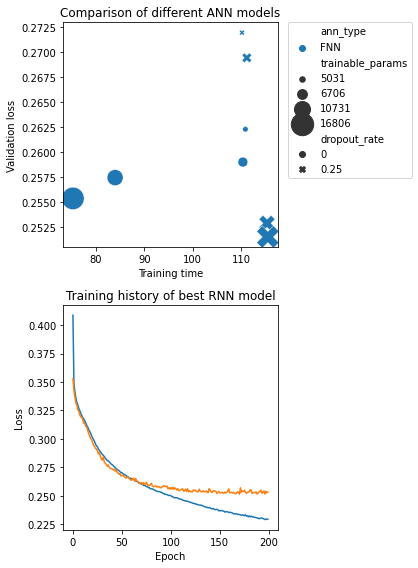

In [ ]:
# code adapted from provided 'UrbanFloodingForecasting.ipynb'

f, axes = plt.subplots(2,1,figsize=(6,8))
sns.scatterplot(
    data=res_df_rnn, x="elapsed_time", y="val_loss", hue="ann_type", style="dropout_rate", size="trainable_params", sizes=(30, 500), ax=axes[0]);
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[0].set_title('Comparison of different ANN models')
axes[0].set_xlabel('Training time')
axes[0].set_ylabel('Validation loss')

best_model_ix = res_df_rnn['val_loss'].astype(float).idxmin();
axes[1].plot(rs[best_model_ix].history['loss'],label='Training loss');
axes[1].plot(rs[best_model_ix].history['val_loss'],label='Validation loss');
axes[1].set_title('Training history of best RNN model');
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
f.tight_layout()


# Analysis Question 1
After running several different FNN architectures, it appears as if the FNN architecture with 100 neurons, a drop out rate of 0.25, an learning rate of 0.01, batch size of 256, 2 FNN layers, and 16806 trainable parameters performs best.  This model has the lowest validation loss compared to the other models.  This model also has the highest validation accuracy of all models.  The f1 score for this architecture is also relatively strong (0.562465) in comparison to other model f1 scores.


#### Part 2. <u> Train multiple Recurrent Neural Networks architectures</u>.

You are asked to train several preliminary RNNs architectures (between 6 and 18) to identify a suitable recurrent architecture for *water end-use multiclass classification*. The most promising RNN model will be refined later in the assignment. 

_Instructions_
- Try SimpleRNN as well as LSTM;
- Limit the total number of neurons to 100;
- Try both Unidirectional as well as Bidirectional RNNs;
- Use dropout and early stopping (callback) to reduce overfitting;
- Limit training epochs to 200 and use time stopping (callback) to reduce computational time to a max of 5 minutes for each model;
- Use the Adam optimizer, and set learning rate to 0.010;
- Use a batch size of 256.

_Questions_
- For each trained architecture, store the *best value for the validation loss*, *number of trainable parameters*, and *training time*;
- Select the most promising architecture and motivate why. This RNN will be refined later and compared against the benchmark FNN model you developed in the previous section.
- Plot the training/validation history of the selected RNN architecture;



In [ ]:
#Model
def get_trainable_parameters(model):
  number_of_weights = [K.count_params(w) for w in model.trainable_weights]
  k = 0           #can be looped over more layers
  for layer in model.layers:
    print('_ _ _ '*10)
    print(layer.name)
    for weights in layer.trainable_weights:
      print(f'{weights.name}, \nshape={weights.shape} ===> {number_of_weights[k]}')
      k+=1
  print('_ _ _ '*10)
  total = np.array(number_of_weights).sum().astype(int)
  print(f'Total = {total}')
  return total

#Inputs
L = 60      # sequence length
H = 100     # number of neurons

totals = pd.Series(index=['SimpleRNN','LSTM','BiSimpleRNN'], dtype=np.int64)

In [ ]:
def RNNmodel(n_hidden_neurons=10, cell_type=('LSTM','BiSimpleRNN','BiLSTM'), dropout_rate=0.2):
  i = Input(shape=(L,1))
  if cell_type == 'SimpleRNN':
      x = SimpleRNN(n_hidden_neurons, activation='tanh', return_sequences=False, name='SimpleRNN')(i)
  elif cell_type == 'LSTM':
      x = LSTM(n_hidden_neurons, activation='tanh', name='LSTM')(i)
  elif cell_type == 'BiSimpleRNN':
      x = Bidirectional(SimpleRNN(n_hidden_neurons, activation='tanh', return_sequences=False, name='SimpleRNN'))(i)
  elif cell_type == 'BiLSTM':
      x = Bidirectional(LSTM(n_hidden_neurons, activation='tanh', name='LSTM'))(i)
  else:
    raise Exception("Error: Cell type not recognized! Choose between 'SimpleRNN','LSTM', or 'BiSimpleRNN'.")    
  x = Dropout(dropout_rate)(x)
  x = Dense(6, activation='sigmoid', name='Output')(x)
  model = Model(i,x)
  return model

In [ ]:
# create model combinations (using itertools product)
ANN_type = ['SimpleRNN','LSTM','BiSimpleRNN','BiLSTM']
neurons = [75,100]
dropout_rate = [0,0.25]
lr = [0.01]
batch_size = [256]

all_combinations = list(itertools.product(*[ANN_type,neurons,dropout_rate,lr,batch_size]))
print(pd.DataFrame(data=all_combinations, columns=['ann_type','neurons','dropout_rate','lr','batch_size']))

       ann_type  neurons  dropout_rate    lr  batch_size
0     SimpleRNN       75          0.00  0.01         256
1     SimpleRNN       75          0.25  0.01         256
2     SimpleRNN      100          0.00  0.01         256
3     SimpleRNN      100          0.25  0.01         256
4          LSTM       75          0.00  0.01         256
5          LSTM       75          0.25  0.01         256
6          LSTM      100          0.00  0.01         256
7          LSTM      100          0.25  0.01         256
8   BiSimpleRNN       75          0.00  0.01         256
9   BiSimpleRNN       75          0.25  0.01         256
10  BiSimpleRNN      100          0.00  0.01         256
11  BiSimpleRNN      100          0.25  0.01         256
12       BiLSTM       75          0.00  0.01         256
13       BiLSTM       75          0.25  0.01         256
14       BiLSTM      100          0.00  0.01         256
15       BiLSTM      100          0.25  0.01         256


In [ ]:
res_df_rnn = pd.DataFrame(index=np.arange(len(all_combinations)), 
                      columns=['ann_type','neurons','dropout_rate','lr','batch_size','model_name',
                               'tr_loss','val_loss','tr_acc','val_acc','val_f1score','elapsed_time','trainable_params'])

rs = [] # histories

for i, combination in enumerate(all_combinations):
  # extract parameters and create model name  
  ANN_type, neurons, dropout_rate, lr, batch_size = combination
  model_name = f"{ANN_type}_neurons={neurons}_dropout={dropout_rate}_lr={lr}_bsize={batch_size}"
  # store in res_df 
  res_df_rnn.loc[i,['ann_type','neurons', 'dropout_rate','lr','batch_size','model_name']] = combination + (model_name,)

  # call backs
  earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1,  min_delta=1e-6, mode='auto')
  modelCheckpoint = ModelCheckpoint(f'{working_folder}{model_name}.hdf5', save_best_only=True, monitor='val_loss', mode='auto', save_weights_only=True)
  timeStopping = tfa.callbacks.TimeStopping(seconds=5*60, verbose=1)  
  callbacks = [earlyStopping, modelCheckpoint, timeStopping]

  # create model
  model = RNNmodel(n_hidden_neurons = neurons,cell_type=ANN_type, dropout_rate = dropout_rate)

  # compile
  model.compile(loss='binary_crossentropy',optimizer=Adam(lr=lr), metrics=['accuracy'])

  # echo screen
  print(f'Training {model_name}, #{i+1} of {len(all_combinations)}')
  # train
  start_time = time.time()
  r = model.fit(Xtra, Ytra,epochs=200,validation_data = (Xval, Yval), callbacks=callbacks, verbose=0, batch_size=batch_size)
  # append history
  rs.append(r)
  # store results
  res_df_rnn.loc[i,'elapsed_time'] = time.time() - start_time
  best_ix = np.array(r.history['val_loss']).argmin()
  res_df_rnn.loc[i,['tr_loss','val_loss','tr_acc','val_acc']] = [r.history['loss'][best_ix],r.history['val_loss'][best_ix],
                                                                 r.history['accuracy'][best_ix],r.history['val_accuracy'][best_ix]]     
  res_df_rnn.loc[i,'trainable_params'] = get_trainable_params(model)
  # load weights and compute f1_score
  model.load_weights(f'{working_folder}{model_name}.hdf5')
  Yval_pred = (model.predict(Xval)>0.5).astype(int)
  res_df_rnn.loc[i,['val_f1score']] = f1_score(Yval,Yval_pred, average = 'weighted') #'weighted' for average because we have label imbalance (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
  print(res_df_rnn.loc[i,['elapsed_time','val_loss','val_acc','val_f1score']])

Training SimpleRNN_neurons=75_dropout=0_lr=0.01_bsize=256, #1 of 16
Timed stopping at epoch 39 after training for 0:05:00
elapsed_time     301.399
val_loss        0.440126
val_acc         0.251506
val_f1score            0
Name: 0, dtype: object
Training SimpleRNN_neurons=75_dropout=0.25_lr=0.01_bsize=256, #2 of 16
Timed stopping at epoch 40 after training for 0:05:00
elapsed_time     306.541
val_loss        0.441229
val_acc         0.251506
val_f1score            0
Name: 1, dtype: object
Training SimpleRNN_neurons=100_dropout=0_lr=0.01_bsize=256, #3 of 16
Timed stopping at epoch 40 after training for 0:05:00
elapsed_time     306.359
val_loss        0.440816
val_acc         0.251506
val_f1score            0
Name: 2, dtype: object
Training SimpleRNN_neurons=100_dropout=0.25_lr=0.01_bsize=256, #4 of 16
Timed stopping at epoch 40 after training for 0:05:00
elapsed_time     306.914
val_loss        0.441572
val_acc         0.251506
val_f1score            0
Name: 3, dtype: object
Training LST

In [ ]:
# save df of results
res_df_rnn.to_csv(working_folder + 'Model_rnn_results.csv')

In [ ]:
#Compare the results
res_df_rnn.sort_values(by='val_loss')

,ann_type,neurons,dropout_rate,lr,batch_size,model_name,tr_loss,val_loss,tr_acc,val_acc,val_f1score,elapsed_time,trainable_params
13,BiLSTM,75,0.25,0.01,256,BiLSTM_neurons=75_dropout=0.25_lr=0.01_bsize=256,0.18858,0.191456,0.733739,0.724299,0.716687,300.431,47106
6,LSTM,100,0,0.01,256,LSTM_neurons=100_dropout=0_lr=0.01_bsize=256,0.192965,0.198444,0.723199,0.718588,0.70793,176.633,41406
15,BiLSTM,100,0.25,0.01,256,BiLSTM_neurons=100_dropout=0.25_lr=0.01_bsize=256,0.19761,0.200092,0.712555,0.715472,0.698829,300.975,82806
14,BiLSTM,100,0,0.01,256,BiLSTM_neurons=100_dropout=0_lr=0.01_bsize=256,0.186175,0.201219,0.733757,0.718899,0.715512,300.658,82806
7,LSTM,100,0.25,0.01,256,LSTM_neurons=100_dropout=0.25_lr=0.01_bsize=256,0.201847,0.203122,0.707622,0.709346,0.690013,183.666,41406
4,LSTM,75,0,0.01,256,LSTM_neurons=75_dropout=0_lr=0.01_bsize=256,0.196695,0.204589,0.715722,0.706231,0.691249,143.547,23556
12,BiLSTM,75,0,0.01,256,BiLSTM_neurons=75_dropout=0_lr=0.01_bsize=256,0.208753,0.212022,0.697982,0.69865,0.682662,246.803,47106
5,LSTM,75,0.25,0.01,256,LSTM_neurons=75_dropout=0.25_lr=0.01_bsize=256,0.43606,0.377258,0.268787,0.380685,0.00975036,71.1607,23556
8,BiSimpleRNN,75,0,0.01,256,BiSimpleRNN_neurons=75_dropout=0_lr=0.01_bsize...,0.444212,0.439142,0.229707,0.251506,0,305.854,12456
10,BiSimpleRNN,100,0,0.01,256,BiSimpleRNN_neurons=100_dropout=0_lr=0.01_bsiz...,0.444576,0.439392,0.232459,0.251506,0.00288968,309.741,21606


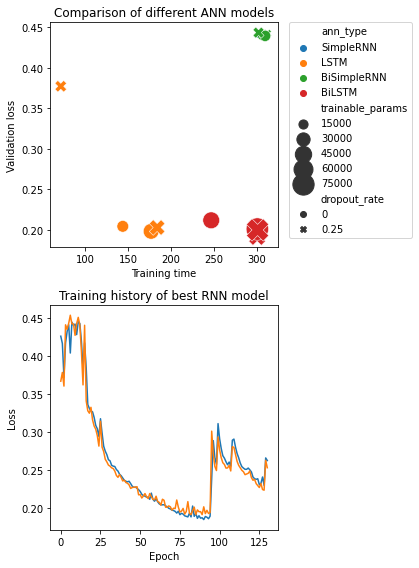

In [ ]:
#Plotting results
f, axes = plt.subplots(2,1,figsize=(6,8))
sns.scatterplot(
    data=res_df_rnn, x="elapsed_time", y="val_loss", hue="ann_type", style="dropout_rate", size="trainable_params", sizes=(30, 500), ax=axes[0]);
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[0].set_title('Comparison of different ANN models')
axes[0].set_xlabel('Training time')
axes[0].set_ylabel('Validation loss')

best_model_ix = res_df_rnn['val_loss'].astype(float).idxmin();
axes[1].plot(rs[best_model_ix].history['loss'],label='Training loss');
axes[1].plot(rs[best_model_ix].history['val_loss'],label='Validation loss');
axes[1].set_title('Training history of best RNN model');
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
f.tight_layout()

# Analysis question 2
After running different architectures, it became clear that the bidirectional architecture with LSTM has the lowest validation loss compared to other architectures. Besides, the accuracy and the f1 are the highest of all architectures. Moreover, this RNN structure has 60% less trainable parameters compared to the FNN. This is also what we expected. 


#### Part 3. <u> Refine and compare the best FNN and RNN</u>.

You are asked to refine the most promising architectures of Part 1 and Part 2 to develop a more accurate *water end-use multiclass classification* model. The classification performance of the best of the two refined models will be assessed in the last part of the assignment. 

_Instructions_
- Retrain the best FNN and best RNN of Part 1 and Part 2;
- Use _dropout_ and the _early stopping_ callback to reduce overfitting;
- Use _ModelCheckpoint_ callback to save the best model for each architecture (weights only);
- Use _ReduceLRonPlateau_ or _LearningRateScheduler_ callbacks to reduce the learning rate dynamically as the training progresses;
- Limit training epochs to 1000 and use the TimeStopping callback to reduce computational time to a max of 15 minutes for each model;
- Use the _Adam_ optimizer, and set the _learning rate_ to 0.005;
- Use a _batch size_ of 256.

_Questions_
- For each trained architecture, store the *best value for the validation loss* and *training time*;
- Plot the training/validation history of both models, including the evolution of the learning rate;
- Select the best model based on performances, and explain why.



In [ ]:
# The best FNN model as tested in question 1:
# 100 neurons,	0.25 dropout,	0.01 LR,	256 batch size, 2 layers, got approx. 62% validation accuracy

# function for FNN model creation
def RefFNNmodel(dropout_rate=0.):
  i = Input(shape=(L,))      
  x = Dense(100, activation='sigmoid', name='Hidden_layer_1')(i)
  x = Dense(100, activation='sigmoid', name='Hidden_layer_2')(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(6, activation='sigmoid', name='Output')(x)  
  model = Model(i,x)
  return model

# The best RNN model as tested in question 2:
# Bi-direcitonal LSTM, 75 neurons,	0.25 dropout,	0.01 LR,	256 batch size, got approx. 72% validation accuracy

def RefRNNmodel(dropout_rate=0.25):
  i = Input(shape=(L,1))
  x = Bidirectional(LSTM(75, activation='tanh', return_sequences=False, name='BiLSTM'))(i)
  x = Dropout(dropout_rate)(x)
  x = Dense(6, activation='sigmoid', name='Output')(x)
  model = Model(i,x)
  return model

In [ ]:
dropouts = [0, 0.1, 0.2, 0.3]
reduceLR = [0.75, 0.5, 0.25, 0.1] # reduce the learning rate by up to a factor 10, as noted on https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

all_combinations = list(itertools.product(*[dropouts, reduceLR]))

q3_df = pd.DataFrame(index=np.arange(len(all_combinations)), columns=['dropout', 'lr_factor', 'model_name', 'tr_loss','val_loss','tr_acc','val_acc','val_f1score','elapsed_time','trainable_params'])

rs_fnn = [] # histories

try:
  for i, combination in enumerate(all_combinations):
    dropout, lr_factor = combination
    model_name = f"FNN_dropout={dropout}_lr_factor={lr_factor}"

    q3_df.loc[i,['dropout','lr_factor', 'model_name']] = combination + (model_name,)

    # set up callbacks
    earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1,  min_delta=1e-6, mode='auto')
    modelCheckpoint = ModelCheckpoint(f'{working_folder}{model_name}.hdf5', save_best_only=True, monitor='val_loss', mode='auto', save_weights_only=True)
    timeStopping = tfa.callbacks.TimeStopping(seconds=15*60, verbose=1) # timeout is 15 minutes
    reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=5, min_lr=0.0005) # reduce by factor, up to the minimum, which is 1/10th of the original
    callbacks = [earlyStopping, modelCheckpoint, timeStopping, reduceLROnPlateau]

    # define model
    model = RefFNNmodel(dropout_rate=dropout)

    # compile
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.005), metrics=['accuracy'])

    # start training!
    print(f'Training {model_name}, #{i+1} of {len(all_combinations)}')

    start_time = time.time()
    r = model.fit(Xtra, Ytra,epochs=1000,validation_data = (Xval, Yval), callbacks=callbacks, verbose=0, batch_size=256)
    rs_fnn.append(r)

    # store results
    q3_df.loc[i, 'elapsed_time'] = time.time() - start_time
    best_ix = np.array(r.history['val_loss']).argmin()
    q3_df.loc[i,['tr_loss','val_loss','tr_acc','val_acc']] = [r.history['loss'][best_ix],r.history['val_loss'][best_ix], r.history['accuracy'][best_ix],r.history['val_accuracy'][best_ix]]
    q3_df.loc[i,'trainable_params'] = get_trainable_params(model)

    # load weights and compute f1_score
    model.load_weights(f'{working_folder}{model_name}.hdf5')
    Yval_pred = (model.predict(Xval)>0.5).astype(int)
    q3_df.loc[i,['val_f1score']] = f1_score(Yval,Yval_pred, average = 'weighted') #'weighted' for average because we have label imbalance (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
    print(q3_df.loc[i,['elapsed_time','val_loss','val_acc','val_f1score']])

  q3_df.to_csv(working_folder + 'Q3_fnn_results.csv')
  print(q3_df.sort_values(by='val_loss'))
except KeyboardInterrupt:
  print('User cancelled training!')

Training FNN_dropout=0_lr_factor=0.75, #1 of 16
Epoch 00277: early stopping
elapsed_time     148.356
val_loss        0.251943
val_acc         0.627414
val_f1score     0.570456
Name: 0, dtype: object
Training FNN_dropout=0_lr_factor=0.5, #2 of 16
Epoch 00619: early stopping
elapsed_time     330.937
val_loss        0.255411
val_acc         0.620976
val_f1score     0.571015
Name: 1, dtype: object
Training FNN_dropout=0_lr_factor=0.25, #3 of 16
Epoch 00657: early stopping
elapsed_time     351.073
val_loss        0.252428
val_acc         0.630426
val_f1score      0.57815
Name: 2, dtype: object
Training FNN_dropout=0_lr_factor=0.1, #4 of 16
Epoch 00720: early stopping
elapsed_time      384.79
val_loss        0.252151
val_acc          0.63188
val_f1score     0.578034
Name: 3, dtype: object
Training FNN_dropout=0.1_lr_factor=0.75, #5 of 16
Epoch 00304: early stopping
elapsed_time     163.642
val_loss        0.255708
val_acc          0.62648
val_f1score     0.546263
Name: 4, dtype: object
Train

In [ ]:
best_model_ix = q3_df['val_loss'].astype(float).idxmin();
best_model = pd.DataFrame(rs_fnn[best_model_ix].history)
best_model.to_csv(working_folder + 'fnn_best_model_history.csv')

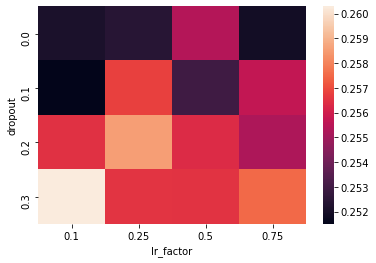

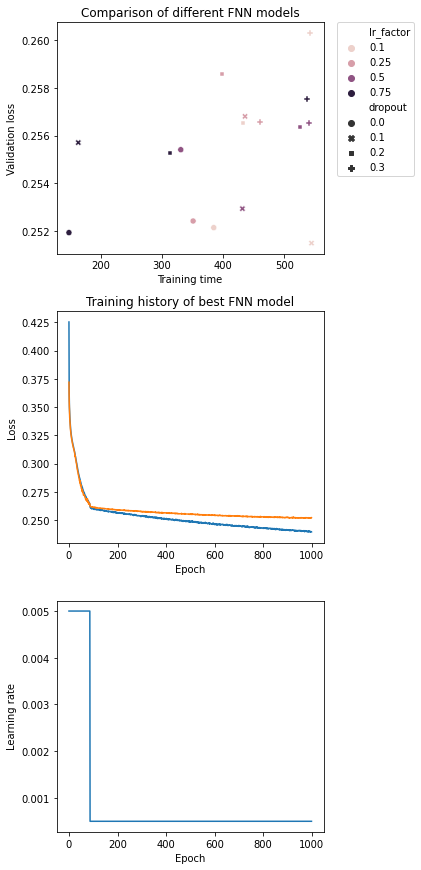

In [ ]:
import seaborn as sns

q3_df = pd.read_csv(working_folder + 'Q3_fnn_results.csv')
data = q3_df[['dropout', 'lr_factor', 'val_loss']]
data = data.pivot(index='dropout', columns='lr_factor', values='val_loss')
sns.heatmap(data)

# plotting results
f, axes = plt.subplots(3,1,figsize=(6,12))
sns.scatterplot(
    data=q3_df, x="elapsed_time", y="val_loss", hue="lr_factor", style="dropout", sizes=(30, 500), ax=axes[0]);
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[0].set_title('Comparison of different FNN models')
axes[0].set_xlabel('Training time')
axes[0].set_ylabel('Validation loss')

# this plot only works if the training was just run, and we have access to the rs_fnn object
try:
  best_model_ix = q3_df['val_loss'].astype(float).idxmin();
  axes[1].plot(rs_fnn[best_model_ix].history['loss'],label='Training loss');
  axes[1].plot(rs_fnn[best_model_ix].history['val_loss'],label='Validation loss');
  axes[1].set_title('Training history of best FNN model');
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Loss')
  f.tight_layout()
    
  axes[2].plot(rs_fnn[best_model_ix].history['lr'], label='Learning rate');
  axes[2].set_xlabel('Epoch')
  axes[2].set_ylabel('Learning rate')
except NameError:
  print('You need to run the training to ensure rs_fnn is defined!')

In [ ]:
dropouts = [0, 0.1, 0.2, 0.3]
reduceLR = [0.75, 0.5, 0.25, 0.1] # reduce the learning rate by up to a factor 10, as noted on https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

all_combinations = list(itertools.product(*[dropouts, reduceLR]))

q3_df_2 = pd.DataFrame(index=np.arange(len(all_combinations)), columns=['dropout', 'lr_factor', 'model_name', 'tr_loss','val_loss','tr_acc','val_acc','val_f1score','elapsed_time','trainable_params'])

rs_rnn = [] # histories

try:
  for i, combination in enumerate(all_combinations):
    dropout, lr_factor = combination
    model_name = f"RNN_dropout={dropout}_lr_factor={lr_factor}"

    q3_df_2.loc[i,['dropout','lr_factor', 'model_name']] = combination + (model_name,)

    # set up callbacks
    earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1,  min_delta=1e-6, mode='auto')
    modelCheckpoint = ModelCheckpoint(f'{working_folder}{model_name}.hdf5', save_best_only=True, monitor='val_loss', mode='auto', save_weights_only=True)
    timeStopping = tfa.callbacks.TimeStopping(seconds=15*60, verbose=1) # timeout is 15 minutes
    reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=5, min_lr=0.0005) # reduce by factor, up to the minimum, which is 1/10th of the original
    callbacks = [earlyStopping, modelCheckpoint, timeStopping, reduceLROnPlateau]

    # define model
    model = RefRNNmodel(dropout_rate=dropout)

    # compile
    model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.005), metrics=['accuracy'])

    # start training!
    print(f'Training {model_name}, #{i+1} of {len(all_combinations)}')

    start_time = time.time()
    r = model.fit(Xtra, Ytra,epochs=1000,validation_data = (Xval, Yval), callbacks=callbacks, verbose=0, batch_size=256)
    rs_rnn.append(r)

    # store results
    q3_df_2.loc[i, 'elapsed_time'] = time.time() - start_time
    best_ix = np.array(r.history['val_loss']).argmin()
    q3_df_2.loc[i,['tr_loss','val_loss','tr_acc','val_acc']] = [r.history['loss'][best_ix],r.history['val_loss'][best_ix], r.history['accuracy'][best_ix],r.history['val_accuracy'][best_ix]]
    q3_df_2.loc[i,'trainable_params'] = get_trainable_params(model)

    # load weights and compute f1_score
    model.load_weights(f'{working_folder}{model_name}.hdf5')
    Yval_pred = (model.predict(Xval)>0.5).astype(int)
    q3_df_2.loc[i,['val_f1score']] = f1_score(Yval,Yval_pred, average = 'weighted') #'weighted' for average because we have label imbalance (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
    print(q3_df_2.loc[i,['elapsed_time','val_loss','val_acc','val_f1score']])

  q3_df_2.to_csv(working_folder + 'Q3_rnn_results.csv')
  print(q3_df_2.sort_values(by='val_loss'))
except KeyboardInterrupt:
  print('User cancelled training!')

Training RNN_dropout=0_lr_factor=0.75, #1 of 16
Epoch 00171: early stopping
elapsed_time     390.307
val_loss        0.195978
val_acc         0.725753
val_f1score     0.718168
Name: 0, dtype: object
Training RNN_dropout=0_lr_factor=0.5, #2 of 16
Timed stopping at epoch 263 after training for 0:10:00
elapsed_time     601.343
val_loss        0.198005
val_acc         0.717445
val_f1score     0.712453
Name: 1, dtype: object
Training RNN_dropout=0_lr_factor=0.25, #3 of 16
Timed stopping at epoch 263 after training for 0:10:00
elapsed_time      600.08
val_loss        0.226405
val_acc         0.674247
val_f1score     0.644259
Name: 2, dtype: object
Training RNN_dropout=0_lr_factor=0.1, #4 of 16
Timed stopping at epoch 263 after training for 0:10:00
elapsed_time     601.312
val_loss        0.204322
val_acc         0.705192
val_f1score     0.694706
Name: 3, dtype: object
Training RNN_dropout=0.1_lr_factor=0.75, #5 of 16
Epoch 00190: early stopping
elapsed_time     440.882
val_loss        0.1912

In [ ]:
best_model_ix = q3_df_2['val_loss'].astype(float).idxmin();
best_model = pd.DataFrame(rs_rnn[best_model_ix].history)
best_model.to_csv(working_folder + 'rnn_best_model_history.csv')

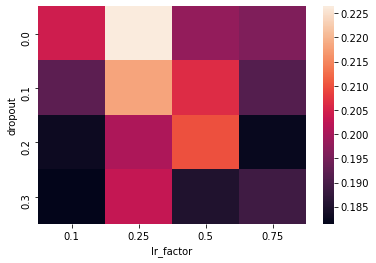

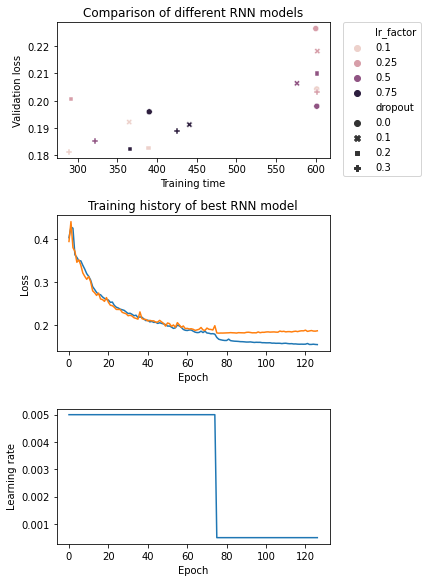

In [ ]:
# read from csv
q3_df_2 = pd.read_csv(working_folder + 'Q3_rnn_results.csv')

# plotting heatmap
data = q3_df_2[['dropout', 'lr_factor', 'val_loss']]
data = data.pivot(index='dropout', columns='lr_factor', values='val_loss')
sns.heatmap(data)

# plotting results
f, axes = plt.subplots(3,1,figsize=(6,8))
sns.scatterplot(
    data=q3_df_2, x="elapsed_time", y="val_loss", hue="lr_factor", style="dropout", sizes=(30, 500), ax=axes[0]);
axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[0].set_title('Comparison of different RNN models')
axes[0].set_xlabel('Training time')
axes[0].set_ylabel('Validation loss')

# this plot only works if the training was just run, and we have access to the rs_rnn object
try:
  best_model_ix = q3_df_2['val_loss'].astype(float).idxmin();
  axes[1].plot(rs_rnn[best_model_ix].history['loss'],label='Training loss');
  axes[1].plot(rs_rnn[best_model_ix].history['val_loss'],label='Validation loss');
  axes[1].set_title('Training history of best RNN model');
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Loss')
  f.tight_layout()

  axes[2].plot(rs_rnn[best_model_ix].history['lr'], label='Learning rate');
  axes[2].set_xlabel('Epoch')
  axes[2].set_ylabel('Learning rate')
except NameError:
  print('You need to run the training to ensure rs_rnn is defined!')

#### Analysis
For the FNN, we can see that varying the lr_factor for the ReduceLROnPlateau callback and varying the overall dropout, can make a bit of a difference to the final best loss on the validation set. However, this difference is very small. In the end, the model with dropout 0.1 and lr_factor 0.1 ended up getting the best final loss value. The shown learning rate and loss graphs display this configuration.

For the RNN, the difference between the different configurations is a bit more pronounced. The model with the best final loss value, also has a (relatively) short running time, making it an even more attractive option. This one uses a 0.3 dropout combined with a 0.1 lr_factor for the ReduceLROnPlateau. The learning rate and loss over epochs is shown for this configuration in the graphs above.

One final note is that the total running time for the RNN models is 600 seconds, which is 10 minutes, whereas the assignment specified 15 minutes. From the scatter plot that compares the different configurations, it is clear that the models taking up the full 10 minutes were already quite a bit higher in terms of loss value, and not in an absolute sense, let alone relative to the running time, would any of these likely get close to outperforming the configurations with lower loss values and shorter running times, if 5 extra minutes were given.

#### Part 4. <u> Check performances of best ANN on the test dataset </u>.

You are asked to check the classification performances of the best, refined, ANN you trained. 

_Instructions_
- Load the best model weights for the best architecture (saved via ModelCheckpoint) in Part 3;
- Compute predictions on the test dataset;  

_Tasks_
- Plot/print the *confusion matrix* for the test dataset (ground truth vs predictions);
- Print the *classification report* for the test dataset;
- Comment the results. Does the model perform well enough to be employed? Are performances equal across the different classes? If not, why? What are possible causes of misclassification? (note: visualizing typical signatures, like done at the beginning of the notebook might be helpful).



In [82]:
import pandas as pd
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split
import numpy as np

print('Loading CSV file...')
df = pd.read_csv('./gdrive/My Drive/CS4305TU_RNN/household_water_consumption_identification.csv')
end_uses = ['toilet', 'shower', 'faucet', 'clotheswasher', 'dishwasher', 'bathtub']


def create_dataset(df):
    # group each episode (they will be sorted automatically based on current order)
    df_grouped = df.groupby('episode')#[end_uses]
    X, Y = [], []
    for group_name, df_group in df_grouped:
        x = df_group.household.values
        X.append(x)
        y = df_group[end_uses].values
        Y.append(y.sum(axis=0) > 0)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y


# tra = training, val = validation (early stopping), tst = testing (unseen)
L = 60  # 10 minutes episode length, sampled every 10 seconds
print('Creating dataset...')
X, Y = create_dataset(df)
Xtra, Xval, Ytra, Yval = train_test_split(X, Y, test_size=0.25, shuffle=False)
Xval, Xtst, Yval, Ytst = train_test_split(Xval, Yval, test_size=0.5, shuffle=False)

def RefRNNmodel(dropout_rate=0.3):
    i = Input(shape=(L, 1))
    x = Bidirectional(LSTM(75, activation='tanh', return_sequences=False, name='BiLSTM'))(i)
    x = Dropout(dropout_rate)(x)
    x = Dense(6, activation='sigmoid', name='Output')(x)
    model = Model(i, x)
    return model

# define params
dropout = 0.3
lr_factor = 0.1

# define model
print('Creating RNN...')
model = RefRNNmodel(dropout_rate=dropout)

# compile
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])

# load weights and compute f1_score
print('Loading weights...')
model.load_weights('./gdrive/My Drive/CS4305TU_RNN/RNN_dropout=0.3_lr_factor=0.1.hdf5')
print('Making predictions...')
Ytst_pred = (model.predict(Xtst)>0.5).astype(int)

print('Done!')

Loading CSV file...
Creating dataset...
Creating RNN...
Loading weights...
Making predictions...
Done!


Confusion matrix, without normalization
[[1501    7  242    0   14   43]
 [1426   13   59    0   22   55]
 [1821   13  566    0   21   72]
 [ 504    0    4  829  117   88]
 [ 279    1    6  752  273   83]
 [ 574    1   36    0    9  199]]
Normalized confusion matrix
[[8.31e-01 3.87e-03 1.34e-01 0.00e+00 7.75e-03 2.38e-02]
 [9.05e-01 8.25e-03 3.75e-02 0.00e+00 1.40e-02 3.49e-02]
 [7.30e-01 5.21e-03 2.27e-01 0.00e+00 8.42e-03 2.89e-02]
 [3.27e-01 0.00e+00 2.59e-03 5.38e-01 7.59e-02 5.71e-02]
 [2.00e-01 7.17e-04 4.30e-03 5.39e-01 1.96e-01 5.95e-02]
 [7.01e-01 1.22e-03 4.40e-02 0.00e+00 1.10e-02 2.43e-01]]


<Figure size 432x288 with 0 Axes>

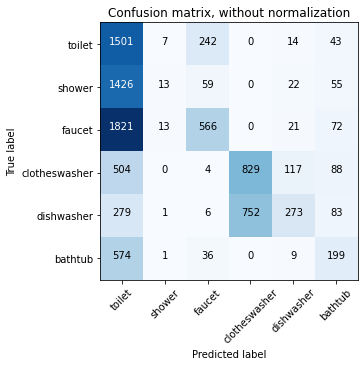

<Figure size 432x288 with 0 Axes>

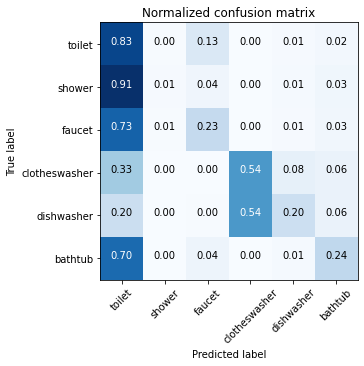

In [86]:
#code taken from assignment_utils.py provided in the assignment
#also referenced https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

def plot_confusion_matrix(cm, classes=end_uses,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,figsize=(5,5)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
    else:
      print('Confusion matrix, without normalization')
    
    print(cm)
    
    f, ax = plt.subplots(1,figsize=figsize)
    ax.imshow(cm, interpolation='nearest', cmap=cmap,)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      ax.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
    
    f.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(Ytst.argmax(axis=1), Ytst_pred.argmax(axis=1))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=end_uses,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=end_uses, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [85]:
#printing classification report
print(classification_report(Ytst, Ytst_pred, target_names=end_uses))

               precision    recall  f1-score   support

       toilet       0.28      0.66      0.39      1807
       shower       0.37      0.01      0.02      1575
       faucet       0.60      0.23      0.34      2493
clotheswasher       0.52      0.54      0.53      1542
   dishwasher       0.61      0.22      0.32      1394
      bathtub       0.37      0.25      0.30       819

    micro avg       0.40      0.32      0.36      9630
    macro avg       0.46      0.32      0.32      9630
 weighted avg       0.47      0.32      0.32      9630
  samples avg       0.32      0.32      0.32      9630



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From our analysis, this model does **not** perform well enough to be deployed. Performance across the board for all classes is "okay" at best and mediocre at worst. For instance water use from a shower is classified as water use from a toilet 91% of the time. But everyone knows that they are vastly different pieces of equipment! The best accuracy seems to be for faucets and dishwashers - 60% and 61% accuracy respectively. This itself is not great by modern ML standards to begin with. It's just that the rest are so bad that ~60% seems good by comparison. These results appear to be in line with what we were told to expect in the lectures given the data we are working with.

We suspect that one major reason for this is the following line of code, which we adapted from the provided examples:

```python
Ytst_pred = (model.predict(Xtst)>0.5).astype(int)
```
So if it sees anything less than 0.5 it will classify that as 0 (toilet), possibly explaining why so many final predicted values are toilets.